# Jet Tagger MLP loss analysis
This notebook aims to show the effect of the hyperparameters on the Jet Tagger model which could be hide to the user due to the approximation of the accuracy metrics.

In [88]:
%reload_ext autoreload
%autoreload 2

# from common.metrics.gradient import Gradient
import torch
from torch.utils.data import DataLoader
import torchinfo
import numpy as np
import pandas as pd
import pytorch_lightning as pl 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from pylab import *
import ast
import os
import sys
from statistics import mean
import warnings

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/jets/code/')) # or the path to your source code
sys.path.insert(0, module_path)
from model import JetTagger
from jet_datamodule import JetDataModule

# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from CKA import CKA
from neural_efficiency import NeuralEfficiency


# import modules from common benchmarks
module_path = os.path.abspath(os.path.join('../../workspace/common/benchmarks/')) # or the path to your source code
sys.path.insert(0, module_path)
from noisy_dataset import NoisyDataset


DATA_PATH="/home/jovyan/checkpoint/"    
DATASET_DIR="../../data/JTAG"
DATASET_FILE=DATASET_DIR + "/processed_dataset.h5"

### Utility methods

In [89]:
def get_model_index_and_relative_accuracy(batch_size, learning_rate, precision, num_tests=5):
    '''
    Return the average EMDs achieved by the model and the index of best experiment
    '''
    performances = []
    max_acc = 0
    max_acc_index = 0
    for i in range (1, num_tests+1):
        file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                    f'JTAG_{precision}b/accuracy_{i}.txt'
        try:
            jtag_file = open(file_path)
            jtag_text = jtag_file.read()
            accuracy = ast.literal_eval(jtag_text)
            accuracy = accuracy[0]['test_acc']
            performances.append(accuracy)
            if accuracy >= max_acc:
                max_acc = accuracy
                max_acc_index = i
            jtag_file.close()
        except Exception as e:
            # warnings.warn("Warning: " + file_path + " not found!")
            continue
        
    if len(performances) == 0:
        # warnings.warn(f"Attention: There is no accuracy value for the model: " \
        #               f"bs{batch_size}_lr{learning_rate}/JTAG_{precision}b")
        #TODO: I may compute if the model is there
        return
    
    return mean(performances), max_acc_index


def plot_2d_heatmap(values, 
                    title, 
                    min_max=(0, 1), 
                    x_label='Layers', 
                    y_label='Layers', 
                    scale_label='Value', 
                    cmap='Greens',
                    show_value=True):
    '''
    Method used to plot a 2D heatmap using Seaborn.
    '''
    # Set up the figure and axes
    plt.figure(figsize=(7, 6))

    # Create a heatmap using Seaborn
    sns.heatmap(values, cmap=cmap, annot=show_value, fmt=".2f", vmin=min_max[0], vmax=min_max[1])

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # plt.colorbar(label=scale_label)

    # Display the plot
    plt.show()


def load_model(batch_size, learning_rate, precision):
    '''
    Method used to get the model and the relative accuracy
    '''
    accuracy, idx = get_model_index_and_relative_accuracy(batch_size, learning_rate, precision)
    model_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/JTAG_{precision}b/net_{idx}_best.pkl'
    
    # load the model
    model = JetTagger(
        quantize=(precision < 32),
        precision=[
            precision,
            precision,
            precision+3
        ],
        learning_rate=learning_rate,
    )
    
    # to set the map location
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model(torch.randn((16, 16)))  # Update tensor shapes 
    model_param = torch.load(model_path, map_location=device)
    model.load_state_dict(model_param['state_dict'])
    
    return model, accuracy


def get_data_module(batch_size, num_workers=12):
    '''
    Method used to get the data modules used during the tests
    '''
    data_module = JetDataModule(
        data_dir=DATASET_DIR,
        data_file=os.path.join(DATASET_DIR, DATASET_FILE),
        batch_size=batch_size,
        num_workers=num_workers)
    
    # checek if we have processed the data
    if not os.path.exists(os.path.join(DATASET_DIR, DATASET_FILE)):
        print('Processing the data...')
        data_module.process_data(save=True)

    data_module.setup(0)
    return data_module

def get_noise_dataloader(batch_size, dataloader, num_workers=12, percentage=5, noise_type='random'):
    noisy_dataset = NoisyDataset(dataloader, 
                                 percentage, 
                                 noise_type)
    return DataLoader(noisy_dataset, 
                      shuffle=False,
                      num_workers=num_workers,
                      batch_size=batch_size)



# EMD distance results

In [90]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

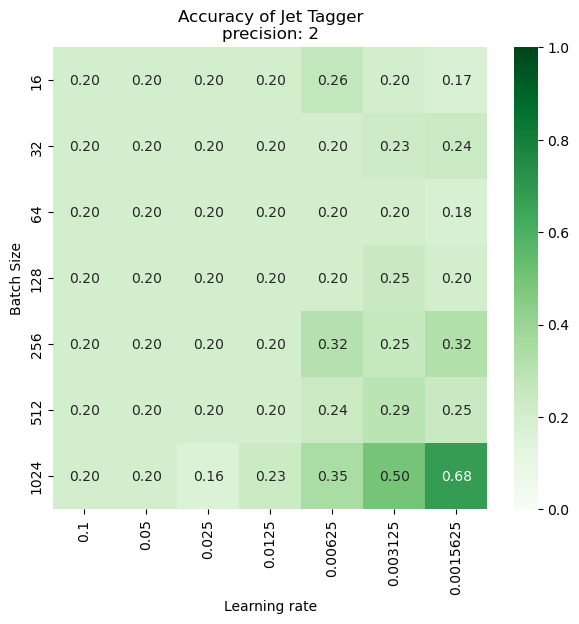

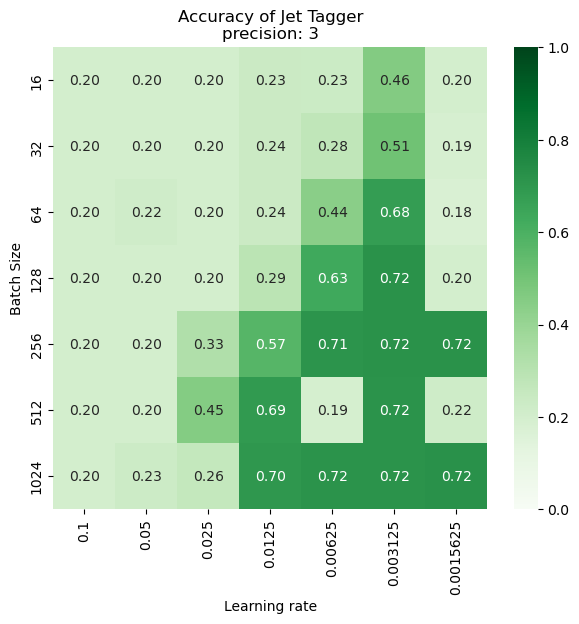

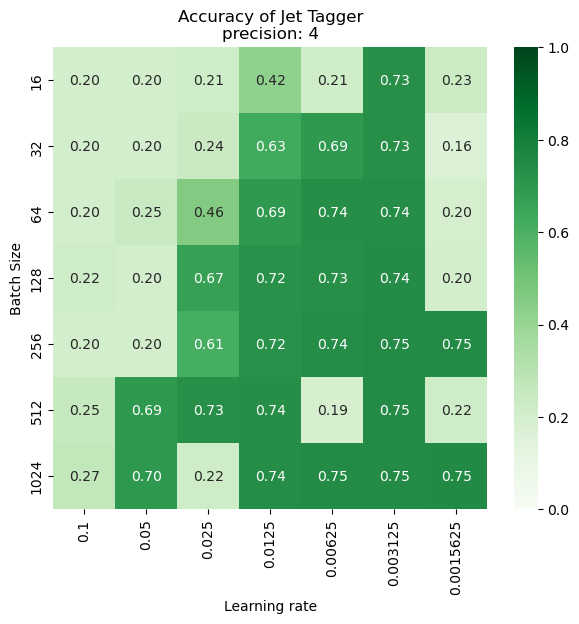

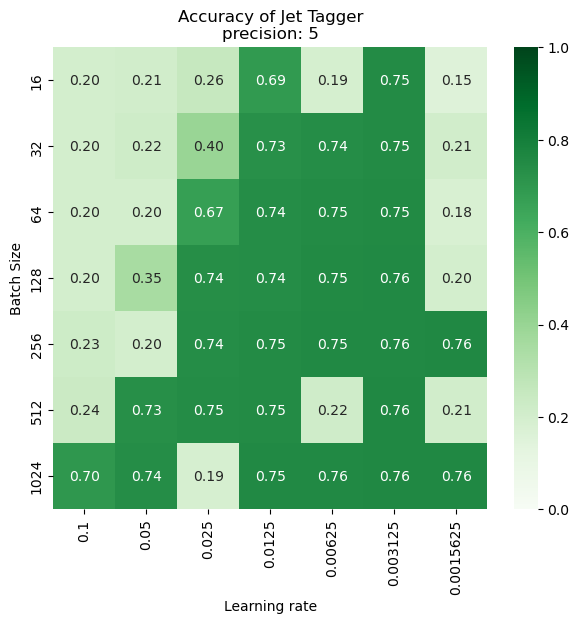

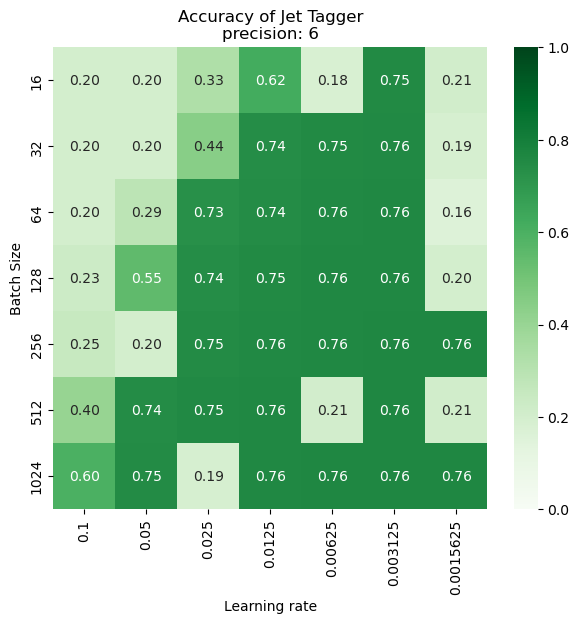

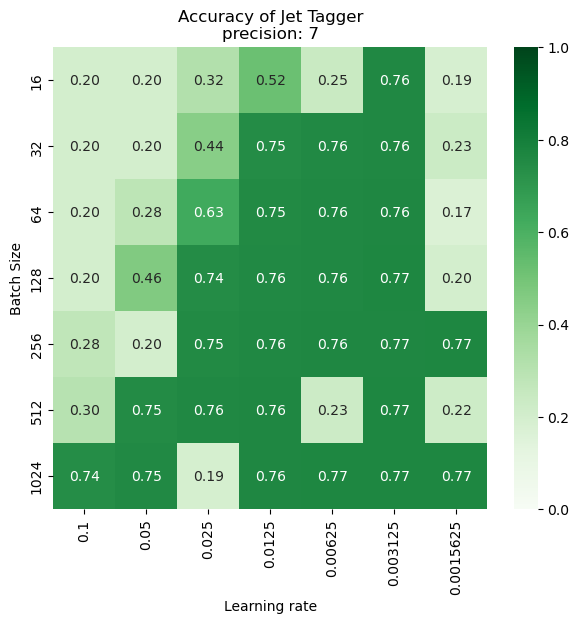

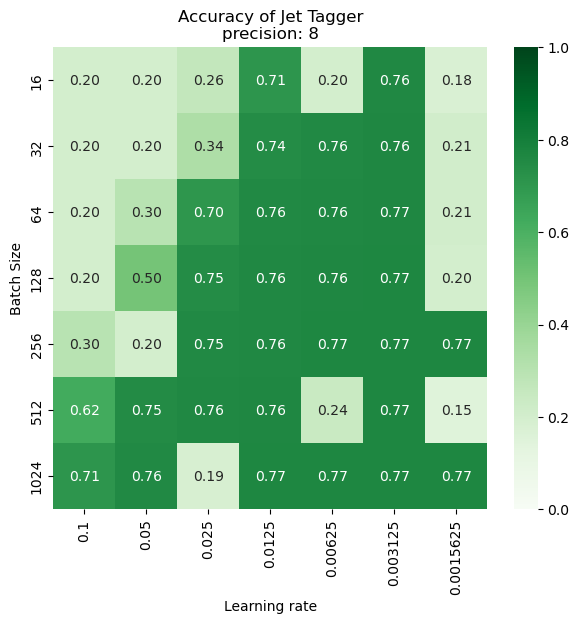

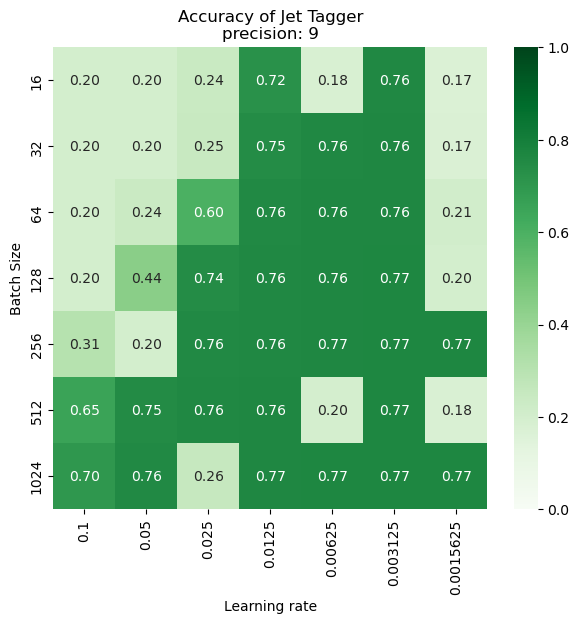

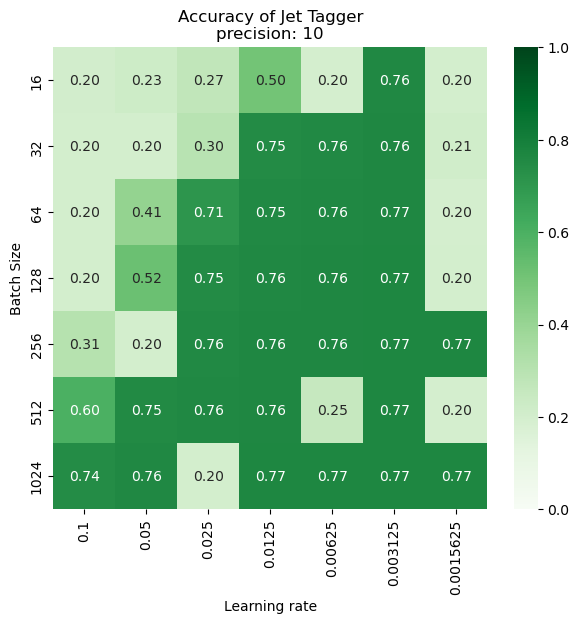

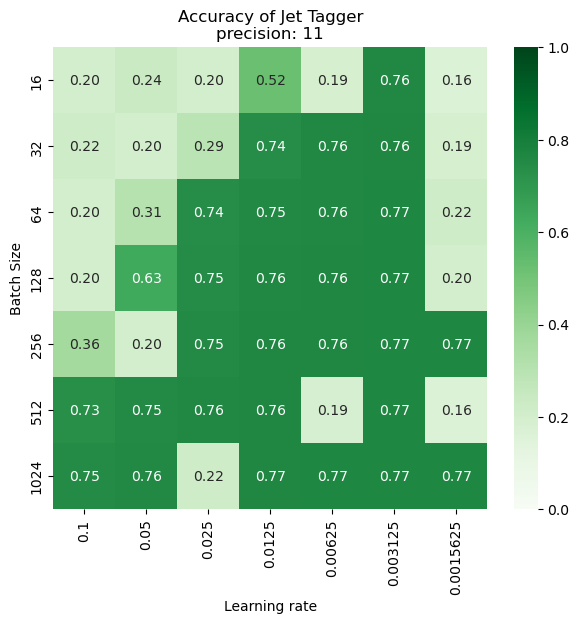

In [91]:
%matplotlib inline

#TODO: 3d heatmap and add noise

# plotting a heat map per layer
for p in precisions:
    accuracy_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_acc, _ = get_model_index_and_relative_accuracy(bs, lr, p)
            accuracy_matrix[x, y] = mean_acc
            
            
    accuracy_matrix = pd.DataFrame(accuracy_matrix, 
                                   index=batch_sizes, 
                                   columns=learning_rates)
    
    plot_2d_heatmap(accuracy_matrix, 
                    f'Accuracy of Jet Tagger\nprecision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'Accuracy')
    


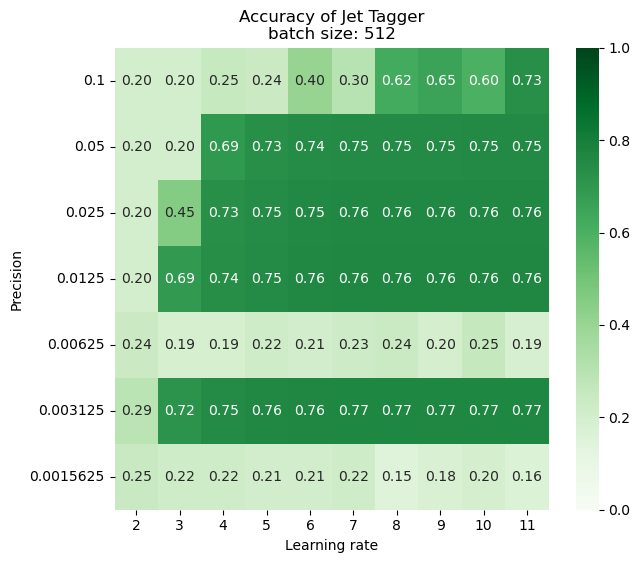

In [92]:
%matplotlib inline

#TODO: 3d heatmap and add noise
batch_size = 512
acc_matrix = np.zeros((len(learning_rates), len(precisions)))
# plotting a heat map per layer
for y, p in enumerate(precisions):
    for x, lr in enumerate(learning_rates):
        mean_acc, _ = get_model_index_and_relative_accuracy(batch_size, lr, p)
        acc_matrix[x, y] = mean_acc
            
            
acc_matrix = pd.DataFrame(acc_matrix, 
                        index=learning_rates, 
                        columns=precisions)

plot_2d_heatmap(acc_matrix, 
                f'Accuracy of Jet Tagger\nbatch size: {batch_size}', 
                (0, 1),
                'Learning rate',
                'Precision',
                'Accuracy')

We want to focus only with models with good performances so we cut out from the analysis the high learning rates.

In [93]:
# plotting a heat map per layer
top_models_count = 3
best_models = {}
worst_models = {}
acc_distribution = []
for p in precisions:
    acc_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_acc, _ = get_model_index_and_relative_accuracy(bs, lr, p)
            acc_matrix[x, y] = mean_acc
            acc_distribution.append({'precision': p, 'accuracy': mean_acc})

    # store best and worst models
    sorted_indices = np.argsort(acc_matrix.flatten(), axis=None)
    
    best_models[p] = []
    worst_models[p] = []
    
    # store the top among best and worst models
    for i in range(top_models_count):
        index = sorted_indices[i]
        best_model_coords = np.unravel_index(index, acc_matrix.shape)
        
        index = sorted_indices[-(i + 1)]
        worst_model_coords = np.unravel_index(index, acc_matrix.shape)
        
        best_models[p].append({
            'model': best_model_coords,
            'accuracy': acc_matrix[best_model_coords]
        })
        
        worst_models[p].append({
            'model': worst_model_coords,
            'accuracy': acc_matrix[worst_model_coords]
        })
        
acc_distribution_df = pd.DataFrame(acc_distribution)

Distribution of the EMD among the different precisions.

<AxesSubplot:xlabel='precision', ylabel='accuracy'>

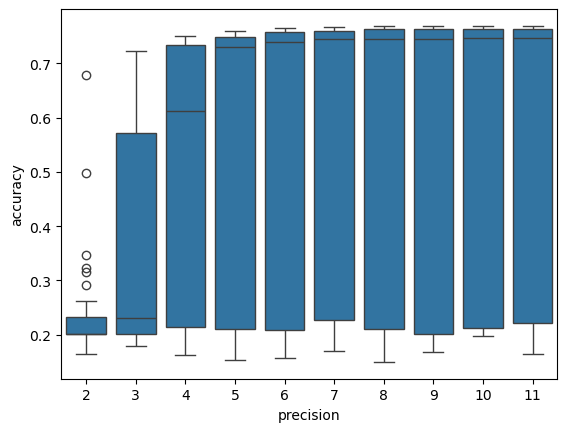

In [94]:
sns.boxplot(data=acc_distribution_df, x='precision', y='accuracy')

Let's discard the precisions 2 and 3 due to low accuracies.

## Scientific Benchmark

In [174]:
precisions = [4, 5, 6, 7, 8, 9, 10, 11]
noise_type = 'gaussian'
percentage = 15 # 5 10 15 20
# TODO: bit flip test

In [330]:
def get_accuracy_with_noise(batch_size, learning_rate, precision, noise_type, percentage):
    '''
    Return the accuracy achieved by the Model with a certain level of noise
    '''

    file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                f'JTAG_{precision}b/accuracy_{noise_type}_{percentage}.txt'
    noise_acc = -1
    try:
        acc_file = open(file_path)
        acc_text = acc_file.read()
        acc = ast.literal_eval(acc_text)
        noise_acc = acc[0]['test_acc']
        acc_file.close()
    except Exception as e:
        # warnings.warn("Warning: " + file_path + " not found!")
        return 0
    return noise_acc

def get_accuracy_with_bitflip(batch_size, learning_rate, precision, number_bit):
    '''
    Return the accuracy achieved by the Model with a certain number of bit flipped
    '''
    file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                f'JTAG_{precision}b/accuracy_bitflip_{number_bit}.txt'
    noise_acc = -1
    try:
        acc_file = open(file_path)
        acc_text = acc_file.read()
        acc = ast.literal_eval(acc_text)
        noise_acc = acc[0]['test_acc']
        acc_file.close()
    except Exception as e:
        # warnings.warn("Warning: " + file_path + " not found!")
        return 0
    return noise_acc

### Bit flip Test

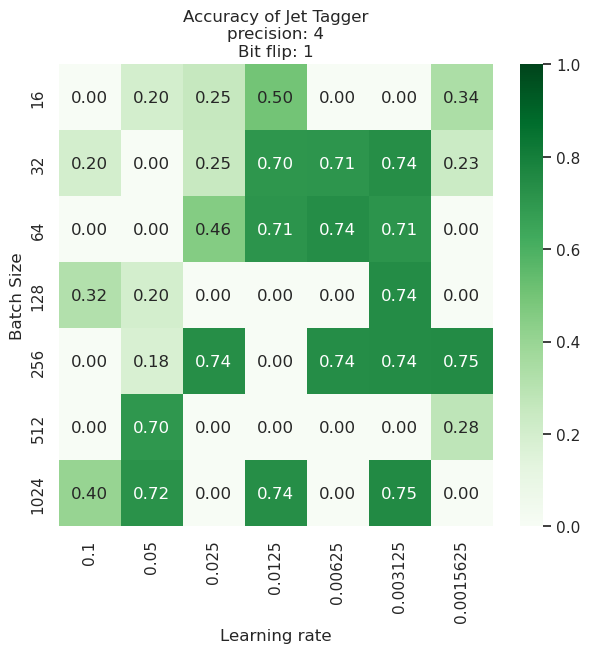

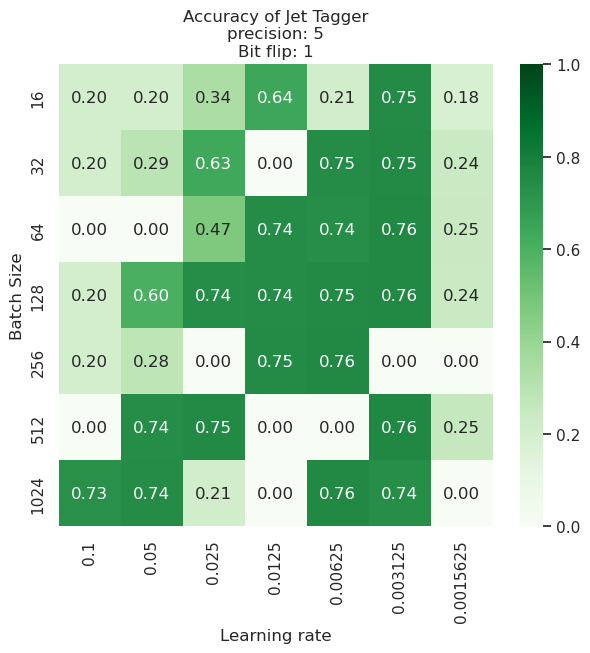

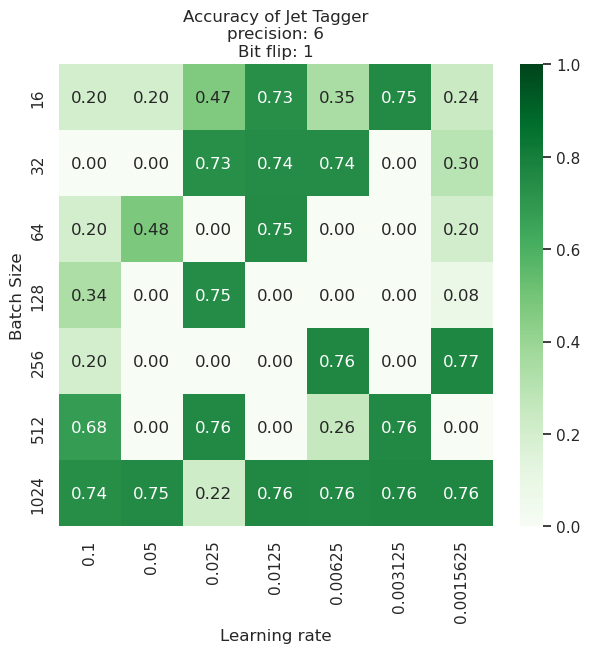

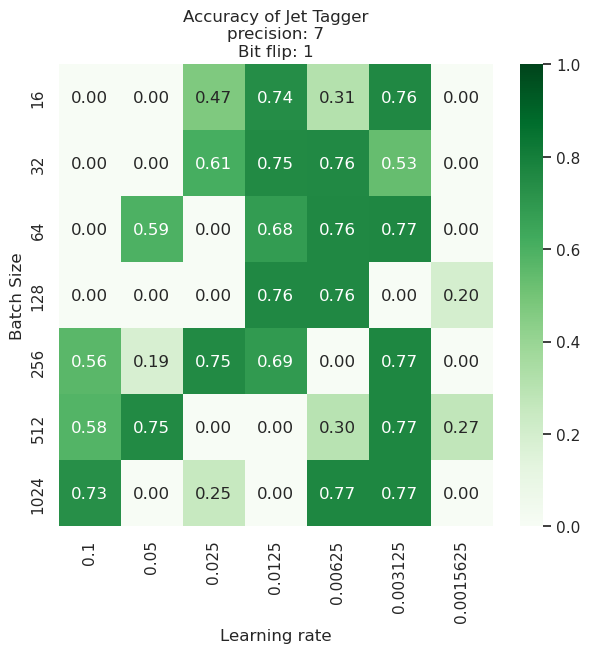

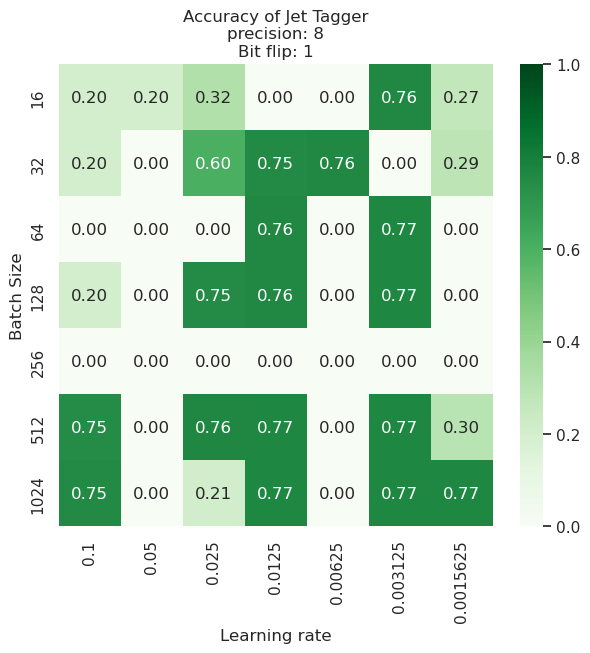

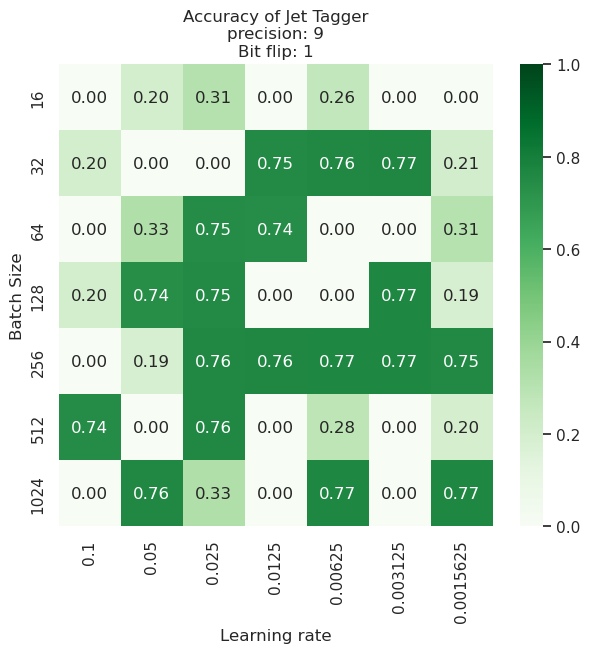

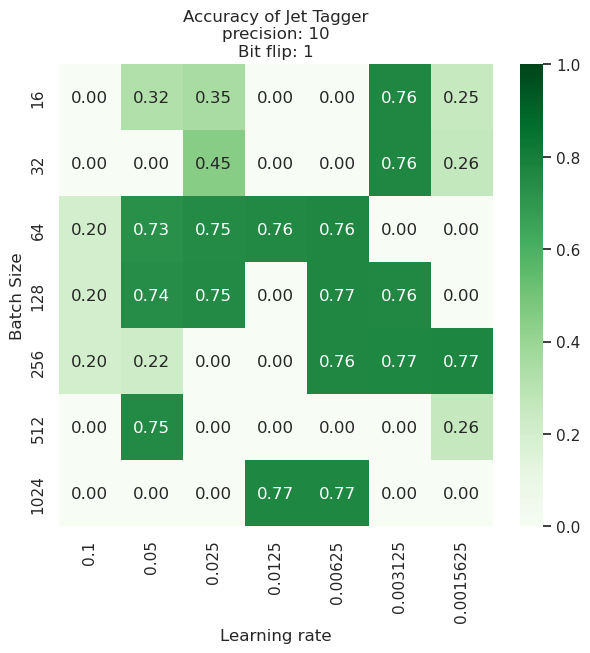

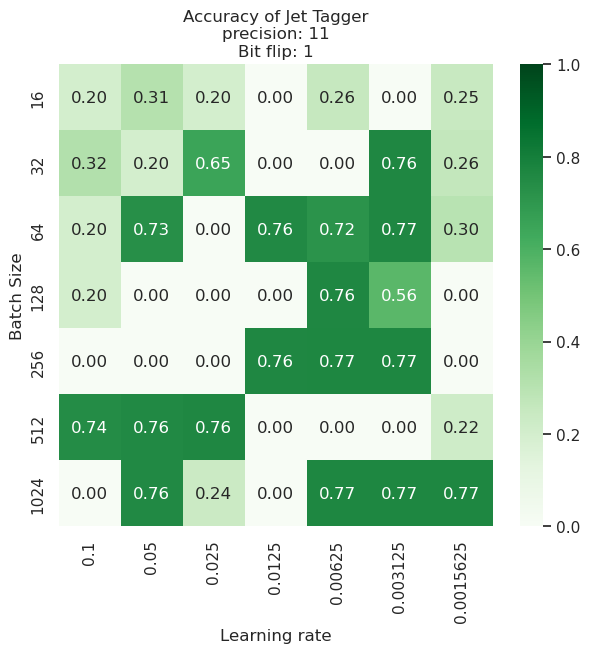

In [331]:
acc_distribution = []
for p in precisions:
    acc_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            bitflip_acc = get_accuracy_with_bitflip(bs, lr, p, 1)
            original_acc, _ = get_model_index_and_relative_accuracy(bs, lr, p)
                        
            acc_matrix[x, y] = bitflip_acc
            acc_distribution.append({
                'precision': p, 
                'accuracy': original_acc,
                'type': 'original',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': str(p),
                'loss': 0
            })
            acc_distribution.append({
                'precision': p, 
                'accuracy': bitflip_acc,
                'type': '1 bit',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': str(p),
                'loss': (original_acc - bitflip_acc) * 100 / original_acc,
                'original_acc': original_acc
            })
            
            
    # heat map of the accuracy with noise as input per precision
    acc_matrix = pd.DataFrame(acc_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    
    plot_2d_heatmap(acc_matrix, 
                    f'Accuracy of Jet Tagger\nprecision: {p}\n' \
                    f'Bit flip: 1', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'Accuracy')
        
acc_distribution_df = pd.DataFrame(acc_distribution)

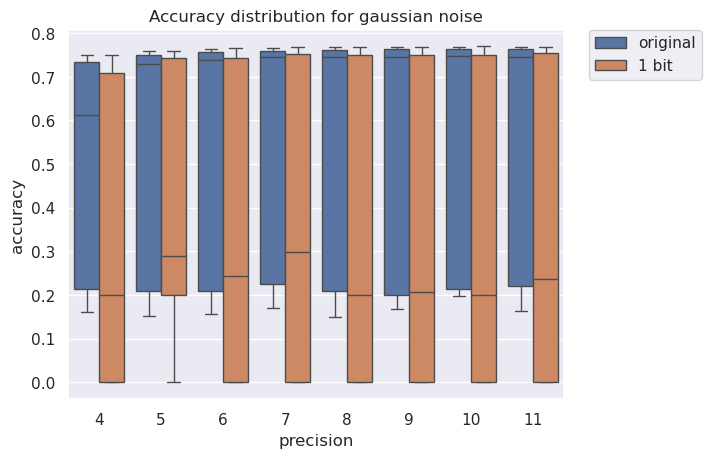

In [332]:

sns.boxplot(data=acc_distribution_df, 
            x='precision', 
            y='accuracy',
            hue='type',
            showfliers=False)

plt.title(f'Accuracy distribution for {noise_type} noise')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

### Noise Test

In [224]:
acc_distribution = []
for p in precisions:
    acc_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            noise_acc_20 = get_accuracy_with_noise(bs, lr, p, noise_type, 20)
            noise_acc_15 = get_accuracy_with_noise(bs, lr, p, noise_type, 15)
            noise_acc_10 = get_accuracy_with_noise(bs, lr, p, noise_type, 10)
            noise_acc_5 = get_accuracy_with_noise(bs, lr, p, noise_type, 5)
            original_acc, _ = get_model_index_and_relative_accuracy(bs, lr, p)
                        
            acc_matrix[x, y] = noise_acc_15
            acc_distribution.append({
                'precision': p, 
                'accuracy': original_acc,
                'type': 'original',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': str(p),
                'loss': 0
            })
            acc_distribution.append({
                'precision': p, 
                'accuracy': noise_acc_5,
                'type': '5%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': str(p),
                'loss': (original_acc - noise_acc_5) * 100 / original_acc,
                'original_acc': original_acc
            })
            acc_distribution.append({
                'precision': p, 
                'accuracy': noise_acc_10,
                'type': '10%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': str(p),
                'loss': (original_acc - noise_acc_10) * 100 / original_acc,
                'original_acc': original_acc
            })
            acc_distribution.append({
                'precision': p, 
                'accuracy': noise_acc_15,
                'type': '15%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': str(p),
                'loss': (original_acc - noise_acc_15) * 100 / original_acc,
                'original_acc': original_acc
            })
            acc_distribution.append({
                'precision': p, 
                'accuracy': noise_acc_20,
                'type': '20%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': str(p),
                'loss': (original_acc - noise_acc_20) * 100 / original_acc,
                'original_acc': original_acc
            })
            
    # heat map of the accuracy with noise as input per precision
    acc_matrix = pd.DataFrame(acc_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    
    # plot_2d_heatmap(acc_matrix, 
    #                 f'Accuracy of Jet Tagger\nprecision: {p}\n' \
    #                 f'Noise {noise_type} {percentage}%', 
    #                 (0, 1),
    #                 'Learning rate',
    #                 'Batch Size',
    #                 'Accuracy')
        
acc_distribution_df = pd.DataFrame(acc_distribution)

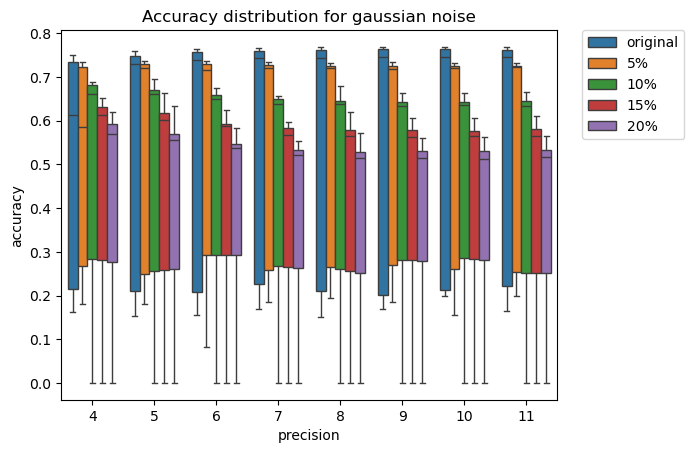

In [225]:
sns.boxplot(data=acc_distribution_df, 
            x='precision', 
            y='accuracy',
            hue='type',
            showfliers=False)

plt.title(f'Accuracy distribution for {noise_type} noise')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

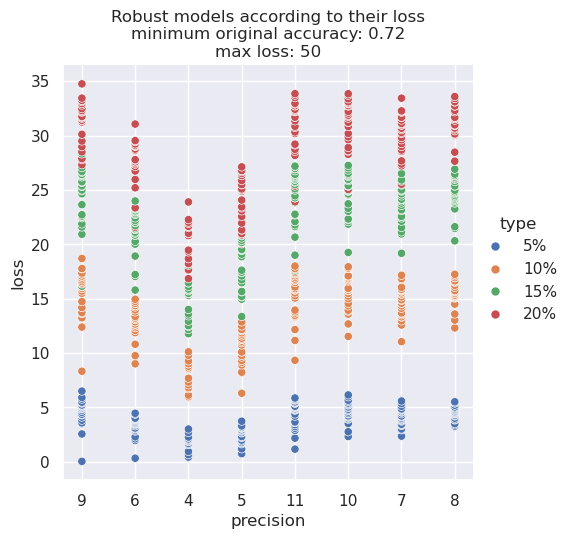

     precision  accuracy type batch_size learning_rate       loss  \
1241         9  0.723321   5%         16        0.0125   0.039499   
571          6  0.725175   5%         64         0.025   0.329860   
156          4  0.721754   5%        256        0.0125   0.402018   
26           4  0.727325   5%         16      0.003125   0.435083   
121          4  0.719721   5%        128        0.0125   0.653595   
...        ...       ...  ...        ...           ...        ...   
1709        10  0.508625  20%       1024      0.003125  33.718922   
1949        11  0.508654  20%       1024       0.00625  33.727567   
1644        10  0.508521  20%        256     0.0015625  33.860339   
1744        11  0.503542  20%         16      0.003125  33.868371   
1459         9  0.500512  20%       1024       0.00625  34.767452   

      original_acc  
1241      0.723607  
571       0.727575  
156       0.724667  
26        0.730503  
121       0.724456  
...            ...  
1709      0.767376  
194

In [312]:
MAX_LOSS = 50
MIN_ACCURACY = 0.72
# filter the entries 
robust_df = acc_distribution_df.sort_values(by=['loss', 'original_acc'], ascending=[True, False])
robust_df = robust_df.drop(robust_df[robust_df.type == 'original'].index)
robust_df = robust_df.drop(robust_df[(robust_df.loss < 0) | (robust_df.loss > MAX_LOSS)].index)
robust_df = robust_df.drop(robust_df[robust_df.original_acc < MIN_ACCURACY].index)

sns.relplot(robust_df, y='loss', x='precision', hue='type')
plt.title(f'Robust models according to their loss\n' \
          f'minimum original accuracy: {MIN_ACCURACY}\n' \
          f'max loss: {MAX_LOSS}')
plt.show()
print(robust_df)

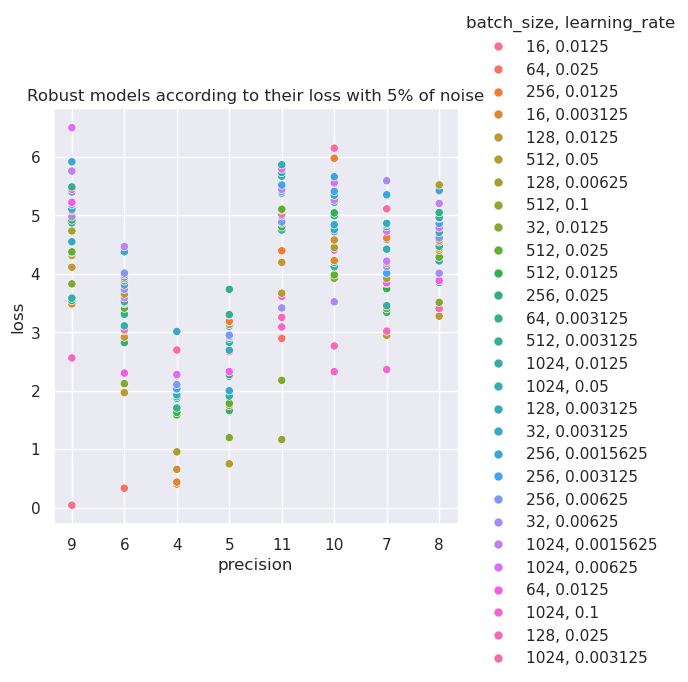

   original_acc      loss batch_size learning_rate precision
0      0.723607  0.039499         16        0.0125         9
1      0.727575  0.329860         64         0.025         6
2      0.724667  0.402018        256        0.0125         4
3      0.730503  0.435083         16      0.003125         4
4      0.724456  0.653595        128        0.0125         4
5      0.732465  0.748390        512          0.05         5
6      0.731738  0.952753        128       0.00625         4
7      0.733644  1.163485        512           0.1        11
8      0.729768  1.195812         32        0.0125         5
9      0.730472  1.584703        512         0.025         4
     original_acc      loss batch_size learning_rate precision
182      0.768859  5.662720        256     0.0015625        10
183      0.765327  5.672188       1024        0.0125        11
184      0.767231  5.735671        512      0.003125        11
185      0.768535  5.759008       1024     0.0015625         9
186      0.767

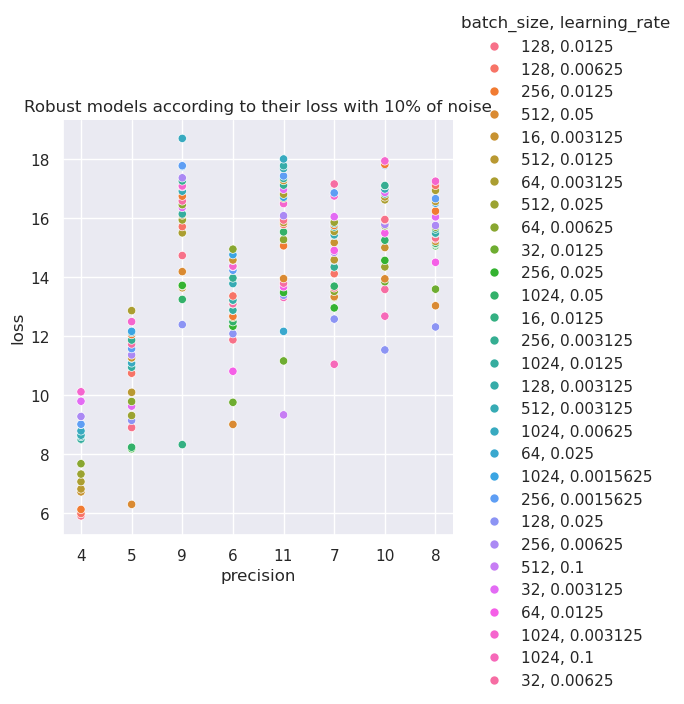

   original_acc      loss batch_size learning_rate precision
0      0.724456  5.915595        128        0.0125         4
1      0.731738  5.994967        128       0.00625         4
2      0.724667  6.134537        256        0.0125         4
3      0.732465  6.306673        512          0.05         5
4      0.730503  6.729264         16      0.003125         4
5      0.735757  6.828345        512        0.0125         4
6      0.740774  7.075257         64      0.003125         4
7      0.730472  7.332136        512         0.025         4
8      0.735488  7.683218         64       0.00625         4
9      0.729768  8.191184         32        0.0125         5
     original_acc       loss batch_size learning_rate precision
190      0.768075  17.432108        256     0.0015625        11
191      0.767231  17.683941        512      0.003125        11
192      0.768535  17.750436       1024     0.0015625         9
193      0.766607  17.777259        128      0.003125        11
194      

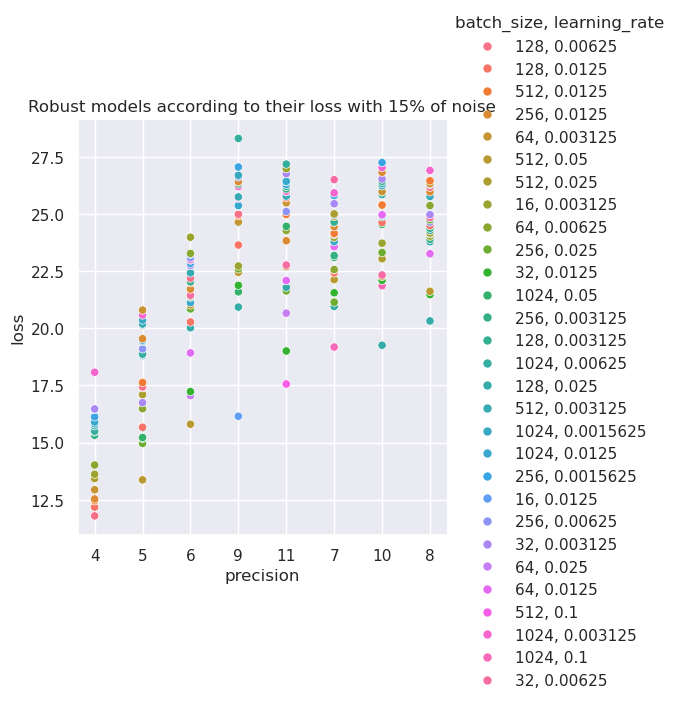

   original_acc       loss batch_size learning_rate precision
0      0.731738  11.784264        128       0.00625         4
1      0.724456  12.170860        128        0.0125         4
2      0.735757  12.448411        512        0.0125         4
3      0.724667  12.525976        256        0.0125         4
4      0.740774  12.928930         64      0.003125         4
5      0.732465  13.362190        512          0.05         5
6      0.730472  13.424089        512         0.025         4
7      0.730503  13.609796         16      0.003125         4
8      0.735488  14.014045         64       0.00625         4
9      0.741505  14.960678        256         0.025         5
     original_acc       loss batch_size learning_rate precision
190      0.768535  26.706330       1024     0.0015625         9
191      0.762710  26.777541         32      0.003125        11
192      0.763453  26.839558        256        0.0125        10
193      0.767931  26.921043       1024      0.003125         

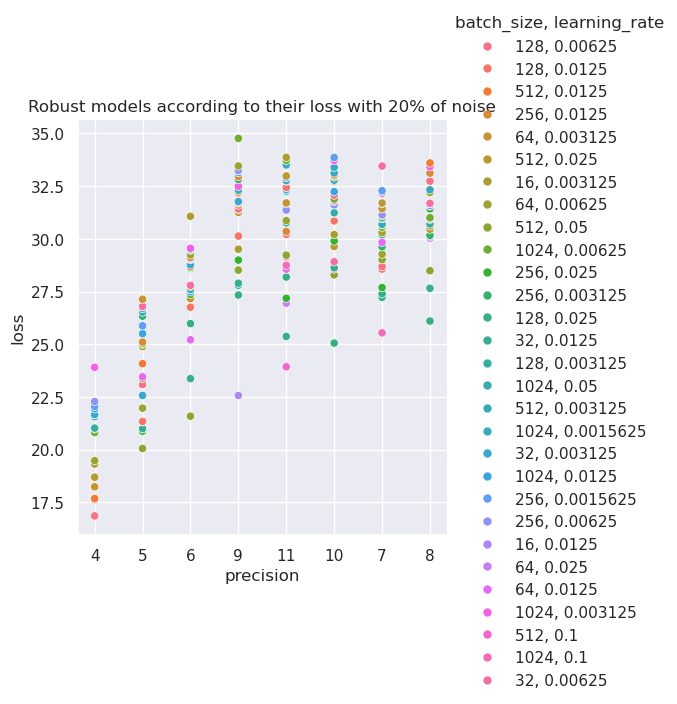

   original_acc       loss batch_size learning_rate precision
0      0.731738  16.848691        128       0.00625         4
1      0.724456  17.621500        128        0.0125         4
2      0.735757  17.676017        512        0.0125         4
3      0.724667  18.213067        256        0.0125         4
4      0.740774  18.231378         64      0.003125         4
5      0.730472  18.686098        512         0.025         4
6      0.730503  19.307917         16      0.003125         4
7      0.735488  19.470740         64       0.00625         4
8      0.732465  20.050216        512          0.05         5
9      0.747554  20.807296       1024       0.00625         4
     original_acc       loss batch_size learning_rate precision
190      0.767931  33.421740       1024      0.003125         8
191      0.755031  33.455253         32       0.00625         7
192      0.761945  33.458673         64       0.00625         9
193      0.762710  33.506838         32      0.003125        1

In [314]:
noise_levels = [5, 10, 15, 20]
for noise in noise_levels:
    # Check the most robust models per noise
    df = robust_df.drop(robust_df[robust_df.type != f'{noise}%'].index)
    df = df.reset_index()

    # we consider couples batch size - learning rates
    hue = df[['batch_size', 'learning_rate']].apply(
        lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
    hue.name = 'batch_size, learning_rate'


    sns.relplot(df, x='precision', y='loss', hue=hue)
    plt.title(f'Robust models according to their loss with {noise}% of noise')
    plt.show()
    print(df[['original_acc', 'loss', 'batch_size', 'learning_rate', 'precision']].head(10))
    print(df[['original_acc', 'loss', 'batch_size', 'learning_rate', 'precision']].tail(10))
    

### NOTE
We can see that some models with really good performances have an higher drop in performances respect to the others, especially models with low precision have a lower drop respect to the models with higher precisions which is really unexpected. 

# CKA similarity anlysis

In [315]:
CKA_DATA_DIR = "./JTAG_cka_distances"

def get_cka_per_model(batch_size, 
                      learning_rate, 
                      precision, 
                      data_loader,
                      activation_layers,
                      max_batches=1000):
    model, _ = load_model(batch_size, learning_rate, precision)
    cka = CKA(model, 
              data_loader, 
              layers=activation_layers,
              name=f'bs{batch_size}_lr{learning_rate}_p{precision}',
              max_batches=max_batches)
    
    return cka


def compute_distance(cka, batch_size, learning_rate, precision, load=True):
    # check if distance already computed
    if load:
        cka.name += f'_bs{batch_size}_lr{learning_rate}_p{precision}'
        if cka.load_from_file(CKA_DATA_DIR):
            return cka.results
        
    model, _ = load_model(batch_size, learning_rate, precision)
    # look if the result has been already computed
    result = cka.compare(model, cka.layers)
    
    # store the result on file
    if not os.path.exists(CKA_DATA_DIR):
        os.mkdir(CKA_DATA_DIR)
        
    cka.save_on_file(path=CKA_DATA_DIR)
    return result


## Structural Analysis
This metric can be used to carry analysis about the internal structure of the model, indeed the CKA similarity is used in XAI field to try to understand the path learned by the model. We are going to use that to see the difference between extreme cases, for both good and bad models. We are carrying our analysis considering high levels of noise to stress the spread of the losses 

*Note*: Due to the architecture of ECON encoder we are only interested in the values on the diagonal of the heatmap, because it does not make sense to compare a Conv layer with a Dense layer.

In [316]:
# During the computation of the CKA similarity both the model must process the same data, 
# so we create a cka_dataloader equal for all the models which we will use to carry on our
# test
cka_dataloader = get_data_module(16).test_dataloader()
cka_batch_num = 100000
jtag_layers = ['model.dense_1', 'model.dense_2', 'model.dense_3', 'model.dense_4']
robust_df.drop(robust_df[robust_df.type != '10%'].index, inplace=True)

Loaded shaped data shape (train): (630000, 16)
Loaded shaped data datatype (train): float32
Loaded shaped data shape (val): (240000, 16)
Loaded shaped data datatype (val): float32


let's see the CKA similarity per layer of the robust models

--------------------------------------------------------------------------------
Low loss
Loading quantized model with bitwidth 4
CUDA available!


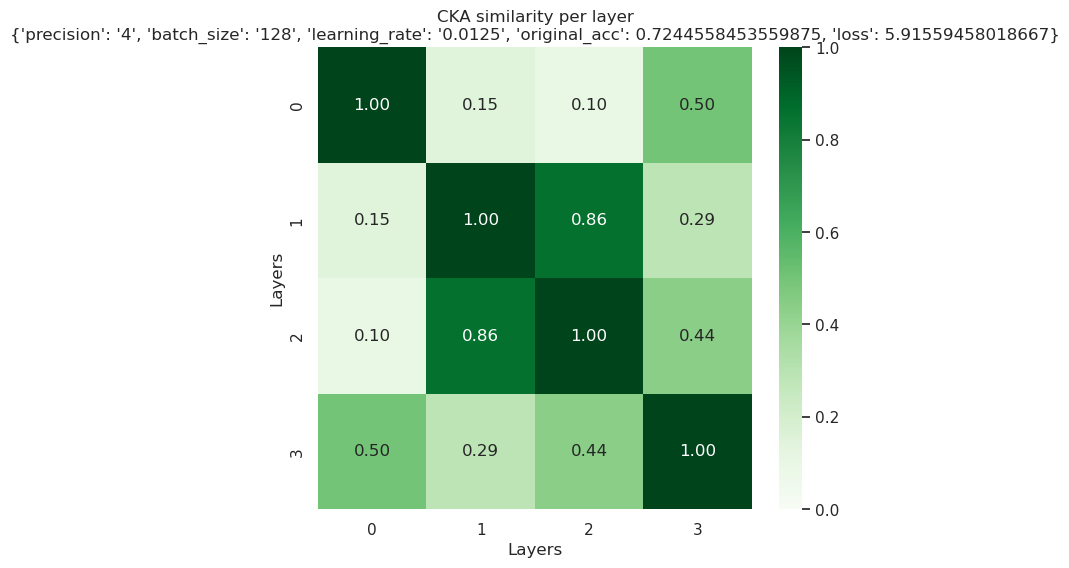

--------------------------------------------------------------------------------
High loss
Loading quantized model with bitwidth 9
CUDA available!


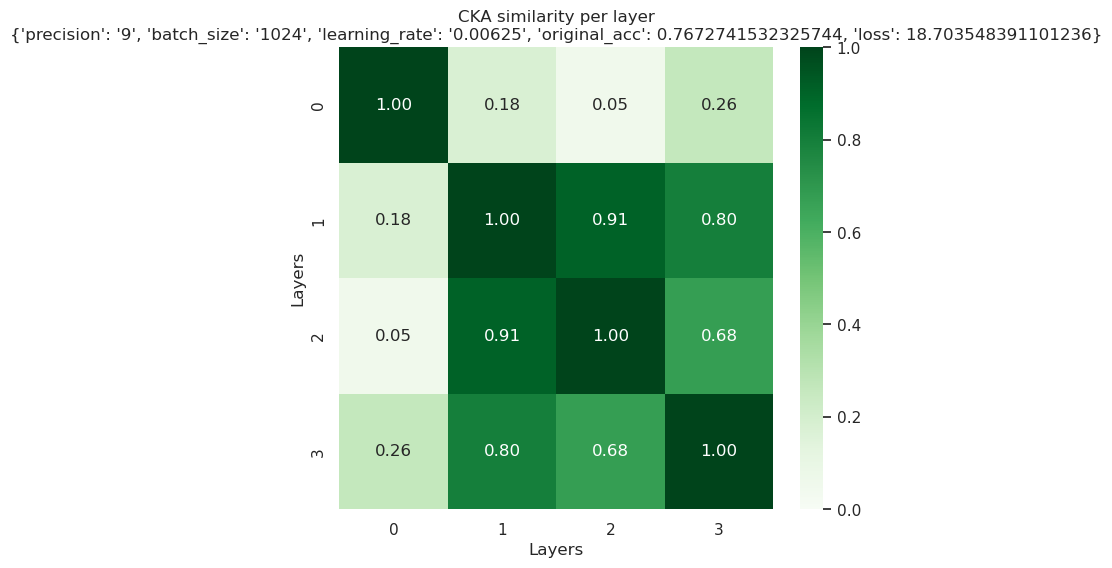

--------------------------------------------------------------------------------
Low loss
Loading quantized model with bitwidth 4
CUDA available!


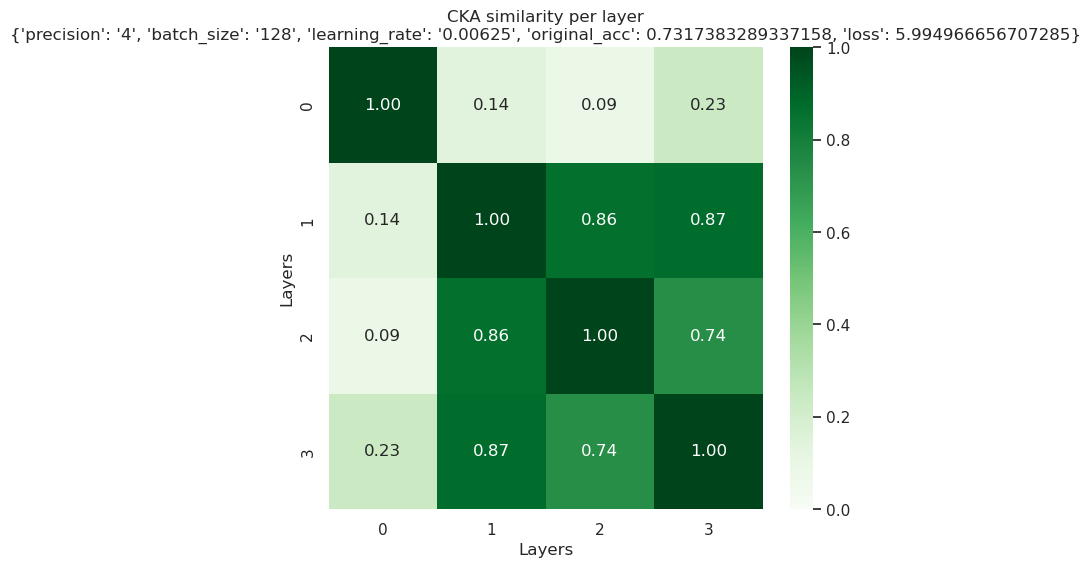

--------------------------------------------------------------------------------
High loss
Loading quantized model with bitwidth 11
CUDA available!


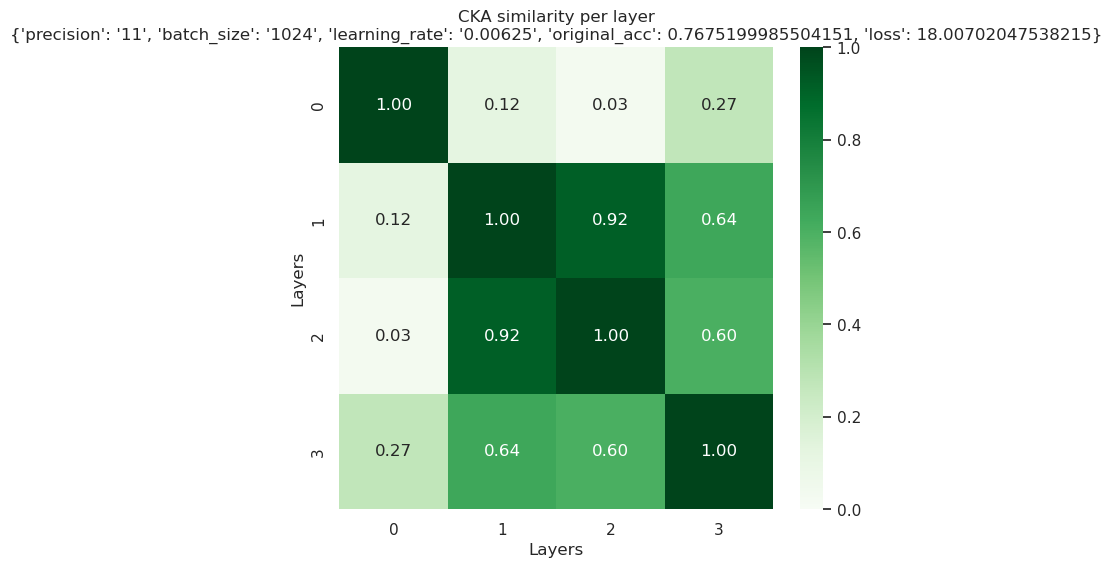

--------------------------------------------------------------------------------
Low loss
Loading quantized model with bitwidth 4
CUDA available!


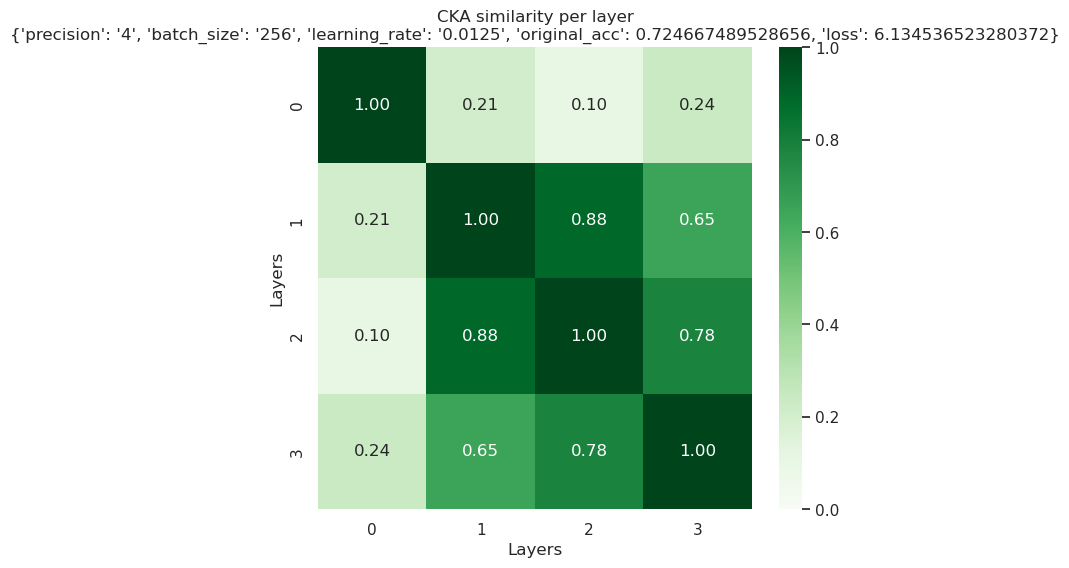

--------------------------------------------------------------------------------
High loss
Loading quantized model with bitwidth 10
CUDA available!


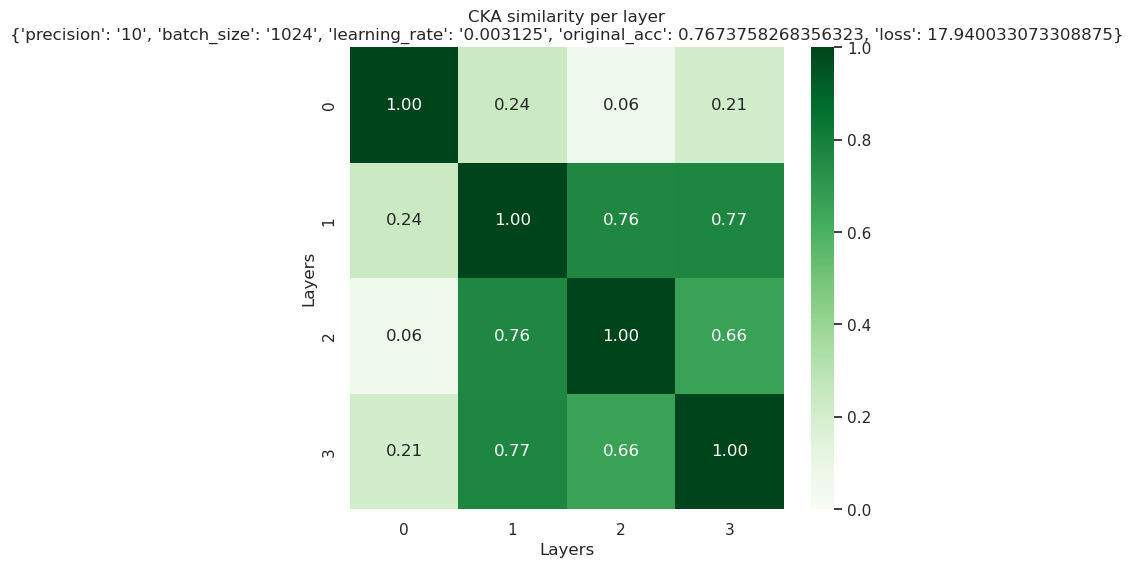

In [317]:
ranking_robust = robust_df[['precision', 'batch_size', 'learning_rate', 'original_acc', 'loss']].to_dict('records')

for i in range(3):
    worst_index = -(i+1)    # last in the ranking
    best_index = i
    
    print('-'*80)
    print('Low loss')
    cka = get_cka_per_model(int(ranking_robust[best_index]['batch_size']),
                            float(ranking_robust[best_index]['learning_rate']), 
                            int(ranking_robust[best_index]['precision']),
                            cka_dataloader,
                            jtag_layers,
                            cka_batch_num)

    results = cka.compute()
    plot_2d_heatmap(results['internal_cka'].cpu().detach().numpy(), 
                    f"CKA similarity per layer\n{ranking_robust[best_index]}", 
                    scale_label='CKA similarity')
    print('-'*80)
    print('High loss')
    cka = get_cka_per_model(int(ranking_robust[worst_index]['batch_size']),
                            float(ranking_robust[worst_index]['learning_rate']), 
                            int(ranking_robust[worst_index]['precision']),
                            cka_dataloader,
                            jtag_layers,
                            cka_batch_num)

    results = cka.compute()
    plot_2d_heatmap(results['internal_cka'].cpu().detach().numpy(), 
                    f"CKA similarity per layer\n{ranking_robust[worst_index]}", 
                    scale_label='CKA similarity')

### NOTE
There is no evident difference between the two models

## Similarity between models

Loading quantized model with bitwidth 4
CUDA available!
Loading the result...
File bs128_lr0.0125_p4_bs1024_lr0.00625_p9.pkl not found!
Loading quantized model with bitwidth 9
Storing the result...
Complete
Distance: 0.1195949912071228


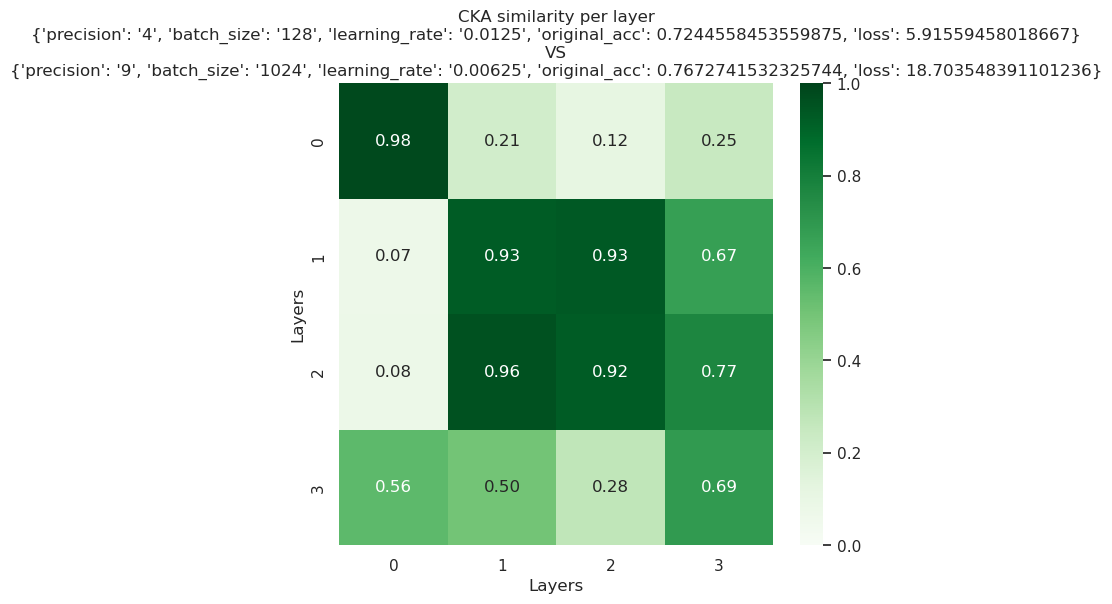

Loading quantized model with bitwidth 4
CUDA available!
Loading the result...
File bs128_lr0.00625_p4_bs1024_lr0.00625_p11.pkl not found!
Loading quantized model with bitwidth 11
Storing the result...
Complete
Distance: 0.04979228973388672


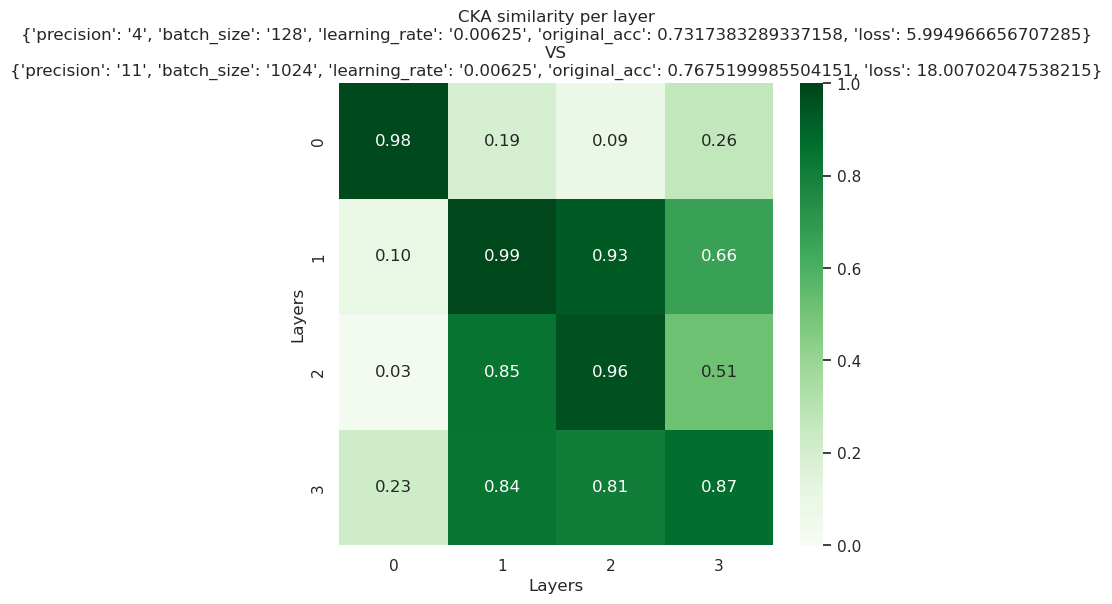

Loading quantized model with bitwidth 4
CUDA available!
Loading the result...
File bs256_lr0.0125_p4_bs1024_lr0.003125_p10.pkl not found!
Loading quantized model with bitwidth 10
Storing the result...
Complete
Distance: 0.12822729349136353


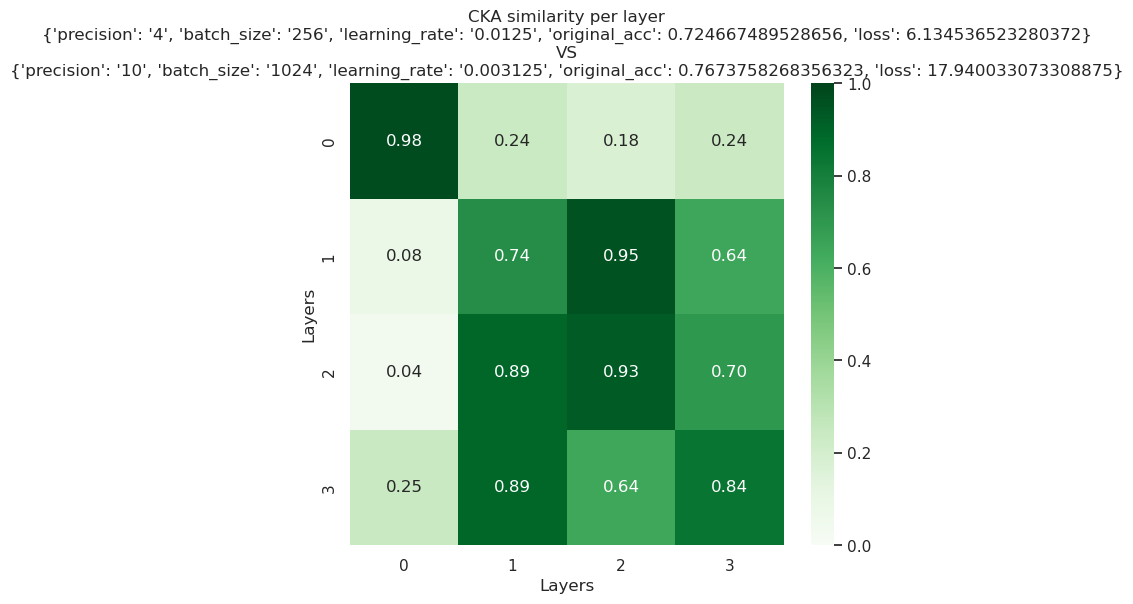

In [318]:
for i in range(3):
    worst_index = -(i+1)    # last in the ranking
    best_index = i

    cka = source_cka = get_cka_per_model(int(ranking_robust[best_index]['batch_size']),
                                         float(ranking_robust[best_index]['learning_rate']), 
                                         int(ranking_robust[best_index]['precision']),
                                         cka_dataloader,
                                         jtag_layers,
                                         cka_batch_num)

    dist = compute_distance(cka,
                            int(ranking_robust[worst_index]['batch_size']),
                            float(ranking_robust[worst_index]['learning_rate']), 
                            int(ranking_robust[worst_index]['precision']))

    print('Distance:', dist['cka_dist'])
    plot_2d_heatmap(dist['compared_cka'].cpu().detach().numpy(), 
                        f"CKA similarity per layer\n{ranking_robust[best_index]}\nVS\n{ranking_robust[worst_index]}", 
                        scale_label='CKA similarity')

### NOTE
Even if there is a large difference in term of loss, the structural distance it's almost the same.

## Compare average similarity among models

In [ ]:
models = robust_rank[-5:].extend(robust_rank[:5])
print(robust_rank[:-5])
num_models = len(models)

distances = np.zeros((num_models, num_models))
        
# compute the distances
for i in range(num_models):
    for j in range(i + 1, num_models):
        source_cka = get_cka_per_model(int(robust_rank[i]['batch_size']),
                                       float(robust_rank[i]['learning_rate']), 
                                       int(robust_rank[i]['precision']),
                                       cka_dataloader,
                                       jtag_layers,
                                       cka_batch_num)
                
        distance = compute_distance(source_cka, 
                                    int(robust_rank[j]['batch_size']),
                                    float(robust_rank[j]['learning_rate']), 
                                    int(robust_rank[j]['precision']),)
        print(distance)
        distance_ij = distance['cka_dist']
        distances[i, j] = distance_ij
        distances[j, i] = distance_ij
           
print(distances)

[{'accuracy': 0.7510683417320252, 'noise': 0.6833500266075134, 'loss': 9.016265413124426, 'batch_size': '1024', 'learning_rate': '0.0015625', 'precision': '4'}, {'accuracy': 0.7502574920654297, 'noise': 0.6696125268936157, 'loss': 10.748971656357808, 'batch_size': '128', 'learning_rate': '0.00625', 'precision': '5'}, {'accuracy': 0.7547691702842713, 'noise': 0.6721000075340271, 'loss': 10.95290666404779, 'batch_size': '1024', 'learning_rate': '0.0125', 'precision': '5'}, {'accuracy': 0.7565366744995117, 'noise': 0.6725749969482422, 'loss': 11.09816356316295, 'batch_size': '1024', 'learning_rate': '0.00625', 'precision': '5'}, {'accuracy': 0.7553716540336609, 'noise': 0.6703125238418579, 'loss': 11.260566866335255, 'batch_size': '128', 'learning_rate': '0.003125', 'precision': '5'}, {'accuracy': 0.7540166735649109, 'noise': 0.6682958602905273, 'loss': 11.368556728209287, 'batch_size': '256', 'learning_rate': '0.00625', 'precision': '5'}, {'accuracy': 0.7590341687202453, 'noise': 0.67112

TypeError: object of type 'NoneType' has no len()

In [ ]:
# perform dimensionality reduction (PCA or t-SNE)
embedding = PCA(n_components=2).fit_transform(distances_matrix)
# embedding = TSNE(n_components=2).fit_transform(distances)
# plot the scatter plot
plt.scatter(embedding[:, 0], embedding[:, 1])

# Annotate points with model index
for index, model in enumerate(top_models):
    plt.annotate(f'{index}', (embedding[index, 0], embedding[index, 1]))
    
plt.title('Model Distances')
plt.show()

NameError: name 'distances_matrix' is not defined

### Compare the structure of the worst models

### Best vs Worst models

## Compare different models
Let's try to compare different models one against the other. The idea is that, if we consider the CKA similarity as a distance among models, we will have that models with similar architecture. The scope of this analysis is to verify if good models are closer one to each other and then see what change if we start to add different percentages of noise.

## Compare the real EMD without the flags of the empty matrix
During the studies of the loss landscape, we discover a strange case in the test of the ECON model. The Econ model is an autoencoder used to compress the information coming from signals that are encoded in a sort of matrix. To evaluate the model we should use the EMD but it is not differentiable, so it is used only as test and the training and evaluation of the model is done with an approximate EMD loss function called Telescope.

Looking at the models with big batch sizes (ex. 512 or 1024) we achieved negative EMD values during the test of the model, but it should not be possible (EMD >= 0). Looking at the implementation of the model we found in the computation of the real EMD thi flag, where if the output of the Encoder is zero set the emd as -0.5 which bias the final average EMD of the model, which in most of the case is actually really high.

<div style="text-align:center">
    <img src="images/EMD_flag.png"></img>
</div>



In [ ]:
def print_old_EMD(size, precision, bs, lr):
    print(f'BATCH SIZE: {bs} - LEARNING RATE {lr} - SIZE {size} - PRECISION {precision}')
    for exp in range(1, 3):
        file_path = base_path + f'bs{bs}_lr{lr}/ECON_{precision}b/{size}/{size}_emd_{exp}.txt'
        try:
            with open(file_path, 'r') as file:
                content = file.read()
                print("AVG EMD: ", content)

        except Exception as e:
            continue


for lr in learning_rate:              
    print_old_EMD('small', 8, 1024, lr)

NameError: name 'learning_rate' is not defined

In [ ]:
trainer = pl.Trainer(
        max_epochs=5,
        accelerator="auto",
        devices=1
    )

def compute_real_EMD(size, precision, bs, lr):
    # load the model 
    model = load_model(base_path, bs, lr, precision, size)
    # get the data loader
    data_module = get_data_module(bs)
    _, val_sum = data_module.get_val_max_and_sum()
    model.set_val_sum(val_sum)
    data_module.setup("test")
    avg_emd = trainer.test(model, dataloaders=data_module.test_dataloader())
    print(f'BATCH SIZE: {bs} - LEARNING RATE {lr} - SIZE {size} - PRECISION {precision}')
    print("AVG EMD: ", avg_emd)
    


compute_real_EMD('small', 8, 1024, 0.1)
print_old_EMD('small', 8, 1024, 0.1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)
Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 341/341 [02:08<00:00,  2.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD            13.577227592468262
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.1 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 13.577227592468262}]
BATCH SIZE: 1024 - LEARNING RATE 0.1 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': -0.19799108803272247}]
AVG EMD:  [{'AVG_EMD': -0.5}]


In [ ]:
compute_real_EMD('small', 8, 1024, 0.05)
print_old_EMD('small', 8, 1024, 0.05)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Testing DataLoader 0: 100%|██████████| 341/341 [02:26<00:00,  2.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD             9.190462112426758
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.05 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 9.190462112426758}]
BATCH SIZE: 1024 - LEARNING RATE 0.05 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 6.228666305541992}]
AVG EMD:  [{'AVG_EMD': 7.037817478179932}]


In [ ]:
compute_real_EMD('small', 8, 1024, 0.0125)
print_old_EMD('small', 8, 1024, 0.0125)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Testing DataLoader 0: 100%|██████████| 341/341 [05:28<00:00,  1.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD            1.1153733730316162
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.0125 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.1153733730316162}]
BATCH SIZE: 1024 - LEARNING RATE 0.0125 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.1153912544250488}]
AVG EMD:  [{'AVG_EMD': 1.1363208293914795}]


In [ ]:
compute_real_EMD('small', 8, 1024, 0.00625)
print_old_EMD('small', 8, 1024, 0.00625)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Testing DataLoader 0: 100%|██████████| 341/341 [05:29<00:00,  1.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD            1.2486552000045776
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.00625 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2486552000045776}]
BATCH SIZE: 1024 - LEARNING RATE 0.00625 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2486635446548462}]
AVG EMD:  [{'AVG_EMD': 1.254514455795288}]


In [ ]:
compute_real_EMD('small', 8, 1024, 0.003125)
print_old_EMD('small', 8, 1024, 0.003125)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Testing DataLoader 0: 100%|██████████| 341/341 [05:25<00:00,  1.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD            1.2884447574615479
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.003125 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2884447574615479}]
BATCH SIZE: 1024 - LEARNING RATE 0.003125 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2883154153823853}]
AVG EMD:  [{'AVG_EMD': 1.318579077720642}]


In [ ]:
compute_real_EMD('small', 8, 1024, 0.0015625)
print_old_EMD('small', 8, 1024, 0.0015625)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Testing DataLoader 0: 100%|██████████| 341/341 [05:31<00:00,  1.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD            1.2459907531738281
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.0015625 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2459907531738281}]
BATCH SIZE: 1024 - LEARNING RATE 0.0015625 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2461320161819458}]
AVG EMD:  [{'AVG_EMD': 1.3005080223083496}]


As we can see from those results, negative values of EMD corresponds to really high values of EMD. I assume that when the model have to deal with large batch size and learning rates it has to process really big and sparse matrix which it just compress as Zero-matrices ignoring all the signals with low intensity. This could not be a problem since we are aware of it, especially because this event is not detected by the telescope loss function which returns good value of EMD. 

# Neural efficiency analysis